In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.datasets import MNIST
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Importing data

In [117]:
root = 'data'
classes = (0, 1)
np.random.seed(42)

# load data
dataset = {'train': MNIST(root=root, train=True, download=True),
            'test': MNIST(root=root, train=False, download=True)}

# create dicts for storing sampled data
labels = ['train', 'test']
X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

pca = PCA(n_components=2)

# for the training and test datasets
for label in labels:
    # sample 600 points for each class
    for c in classes:
        subset_idx = torch.isin(dataset[label].targets, torch.as_tensor(c))
        X[label].append(dataset[label].data[subset_idx].view(-1, 28*28).float()) # flatten to 784x1
        Y[label].append(dataset[label].targets[subset_idx].long())

    # concatenate along the first dimension
    X[label] = torch.cat(X[label], dim=0)
    Y[label] = torch.cat(Y[label], dim=0)

    # convert to numpy
    X[label] = X[label].numpy()
    Y[label] = Y[label].numpy()

    # reshape labels
    Y[label] = np.reshape(Y[label], (len(Y[label]), 1))

    # transform features
    X[label] = pca.fit_transform(X[label])

# scale data (+ convert to np)
scaler = StandardScaler().fit(X['train'])
X['train'] = scaler.transform(X['train'])
X['test'] = scaler.transform(X['test'])

### Question 1: Logistic regression implementation

In [113]:
def augment(matrix):
    # add a column of ones corresponding to the bias weight
    x0 = np.ones((len(matrix), 1))
    X = np.column_stack((matrix, x0))
    return X

def theta_init(X):
    theta = np.random.randn(len(X[0]), 1)
    return theta

def sigmoid(X):
    return 1/(1 + np.exp(-np.clip(X, -500, 500)))

def compute_loss(y, y_pred):
    eps = 1e-15  # small constant to avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y.T @ np.log(y_pred) + (1-y).T @ np.log(1-y_pred))/len(y_pred)

def log_regression(X, Y, lr, n_iter):
    # initialize weights
    theta = theta_init(X['train'])

    m = len(X)
    theta_lst = []

    error = {'train': [], 'test': []}
    loss = {'train': [], 'test': []}

    for i in range(n_iter):
        # calculate gradients vector
        gradients = (2/m)*(X['train'].T @ (sigmoid(X['train'] @ theta) - Y['train']))

        # update weights
        theta = theta - lr*gradients
        theta_lst.append(theta)

        # predict classes
        y_train = sigmoid(X['train'] @ theta)
        y_test = sigmoid(X['test'] @ theta)

        # compute accuracy
        error['train'].append(1 - np.mean((y_train > 0.5) == Y['train']))
        error['test'].append(1 - np.mean((y_test > 0.5) == Y['test']))

        # compute loss
        loss['train'].append(compute_loss(Y['train'], y_train))
        loss['test'].append(compute_loss(Y['test'], y_test))

    return theta_lst, error, loss

# train the model
epochs = 100
learning_rate = 0.01

# augment data
X['train'] = augment(X['train'])
X['test'] = augment(X['test'])

theta, error, loss = log_regression(X, Y, learning_rate, epochs)

### Question 2: Inspecting the training process

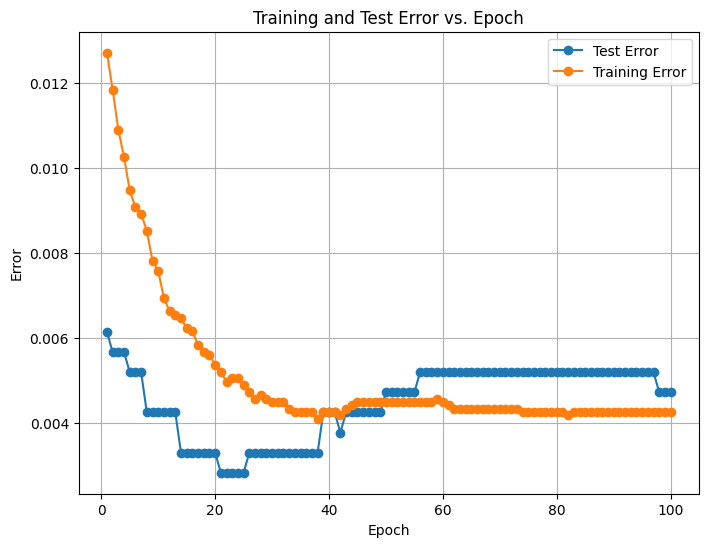

In [114]:
# accuracy vs number of epochs
epochs = [i for i in range(1, 101)]

plt.figure(figsize=(8, 6))
plt.plot(epochs, error['test'], marker='o', linestyle='-', label='Test Error')
plt.plot(epochs, error['train'], marker='o', linestyle='-', label='Training Error')
plt.title('Training and Test Error vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

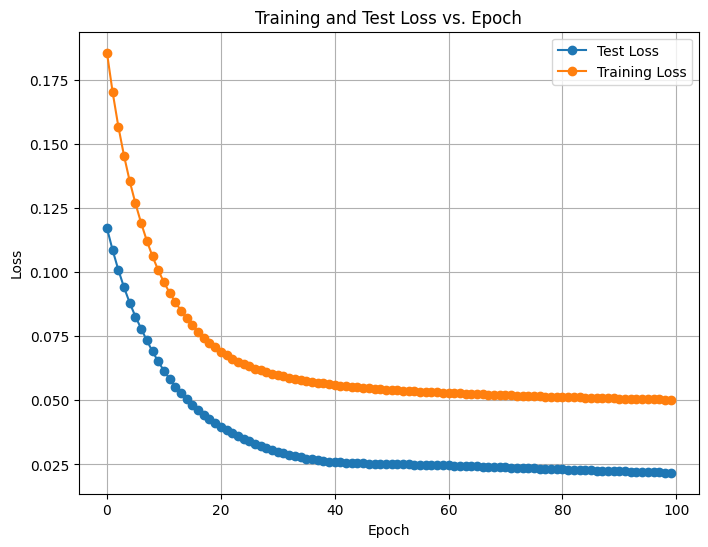

In [105]:
# loss vs number of epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss['test'], marker='o', linestyle='-', label='Test Loss')
plt.plot(epochs, loss['train'], marker='o', linestyle='-', label='Training Loss')
plt.title('Training and Test Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Question 3: Comparing models

In [135]:
# separate class data
c1 = X['train'][(Y['train'].flatten() == 0), :]
c2 = X['train'][(Y['train'].flatten() == 1), :]

In [136]:
# MED classifier
class MEDClassifier:
    def __init__(self, c1, c2):
        self.c1_mean = np.mean(c1, axis=0)
        self.c2_mean = np.mean(c2, axis=0)
        self.boundary = self.c2_mean - self.c1_mean

    def classify(self, sample):
        y = (self.boundary.T @ sample) + 0.5*((self.c1_mean @ self.c1_mean.T) \
          - (self.c2_mean @ self.c2_mean.T))

        if y > 0:
            return 1
        else:
            return 0

MED = MEDClassifier(c1, c2)
MED_pred = []

for sample in X['test']:
    MED_pred.append(MED.classify(sample))

# calculate classification accuracy
MED_error = 1 - np.mean(MED_pred == Y['test'])
print(f"MED test error = {MED_error * 100:.2f}%")

MED test error = 49.69%


In [137]:
# GED classifier
class GEDClassifier:
    def __init__(self, c1, c2):
        self.c1_mean = np.mean(c1, axis=0)
        self.c2_mean = np.mean(c2, axis=0)
        self.c1_cov_inv = np.linalg.inv(np.cov(c1, rowvar=False))
        self.c2_cov_inv = np.linalg.inv(np.cov(c2, rowvar=False))

    def classify(self, sample):
        ged_c1 = np.sqrt((sample - self.c1_mean) @ self.c1_cov_inv @ (sample - self.c1_mean).T)
        ged_c2 = np.sqrt((sample - self.c2_mean) @ self.c2_cov_inv @ (sample - self.c2_mean).T)

        if ged_c1 < ged_c2:
            return 1
        else:
            return 0

GED = GEDClassifier(c1, c2)
GED_pred = []

for sample in X['test']:
    GED_pred.append(GED.classify(sample))

# calculate classification accuracy
GED_error = 1 - np.mean(GED_pred == Y['test'])
print(f"GED test error = {GED_error * 100:.2f}%")

GED test error = 50.24%


In [140]:
# k-NN classifier
class KNNClassifier:
    def __init__(self, k, c1, c2):
        self.k = k
        self.c1 = c1
        self.c2 = c2

    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def classify(self, sample):
        distances_c1 = np.array([self.euclidean_distance(sample, point) for point in self.c1])
        distances_c2 = np.array([self.euclidean_distance(sample, point) for point in self.c2])

        # gett indices of k smallest distances
        indices_c1 = np.argsort(distances_c1)[:self.k]
        indices_c2 = np.argsort(distances_c2)[:self.k]

        # count the number of occurrences of each class
        count_c1 = np.sum(indices_c1)
        count_c2 = np.sum(indices_c2)

        # classify based on majority vote
        if count_c1 < count_c2:
            return 1
        else:
            return 0

KNN = KNNClassifier(5, c1, c2)
KNN_pred = []

for sample in X['test']:
    KNN_pred.append(KNN.classify(sample))

# calculate classification accuracy
KNN_error = 1 - np.mean(KNN_pred == Y['test'])
print(f"k-NN test error = {KNN_error * 100:.2f}%")

k-NN test error = 50.27%


Logistic regression performs the best compared to these classifiers, which is not surprising, considering the amount of overlap in the two classes if plotted in the 2D space. Linear classifiers such as MED and GED cannot effectively separate data with significant overlap, and k-NN classifiers also perform poorly in these scenarios. In contrast, logistic regression can perform very well with overlapping data because it can capture much more complexity for many reasons. First, it introduces non-linearity by using the logistic function, and the likelihood-based approach is much more flexible. Additionally, the optimization by gradient descent iteratively adjusts weights to adapt better to complex data.